In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

from code_utils.path_conf import processed_etri_path, figure_dir

import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm.auto import tqdm
from typing import Iterable
from pathlib import Path


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df_label_tot = pd.read_parquet(processed_etri_path / "labels.parquet")

## Create interaction rate visualizations for all the users

In [6]:
def _get_td_range_df(df_: pd.DataFrame, threshold=pd.Timedelta) -> pd.DataFrame:
    data_list = []
    for date in tqdm(
        pd.date_range(df_.index[0].date(), df_.index[-1].date(), freq="D").tz_localize(
            df_.index.tz
        )
    ):
        df_day = df_[(df_.index > date) & (df_.index < date + pd.Timedelta(days=1))]
        # df_day = df_[date : date + pd.Timedelta(days=1)]
        if not len(df_day):
            continue

        gaps_start = df_day.index.to_series().diff() > threshold
        gaps_start.iloc[[0]] = True

        gaps_end = gaps_start.shift(-1)
        gaps_end.iloc[[-1]] = True

        gaps_start = df_day[gaps_start].index.to_list()
        gaps_end = df_day[gaps_end].index.to_list()
        data_list += [[date, gs, ge] for gs, ge in zip(gaps_start, gaps_end)]

    sessions = pd.DataFrame(data=data_list, columns=["date", "start", "end"])
    sessions["session_dur"] = sessions.end - sessions.start

    sessions = pd.merge(
        sessions,
        sessions.groupby("date")["session_dur"].sum().rename("daily_wear_time"),
        left_on="date",
        right_index=True,
        how="outer",
    )
    return sessions


def get_wearable_session_df(glob: Iterable[Path], fs_exp) -> pd.DataFrame:
    data_list = []
    for eligible_file in glob:
        pqt = pd.read_parquet(eligible_file).set_index("timestamp")
        data_list.append(pqt)

    if not len(data_list):
        return pd.DataFrame()

    df_ = pd.concat(data_list).reset_index()
    if "timestamp" in df_.columns:
        df_ = (
            df_.drop_duplicates(subset=["timestamp"])
            .sort_values(by=["timestamp"])
            .set_index("timestamp")
        )
    del data_list

    return _get_td_range_df(df_, threshold=pd.Timedelta(seconds=1.1 / fs_exp))


def get_label_interaction_df(df_user_label: pd.DataFrame) -> pd.DataFrame:
    if "timestamp" in df_user_label.columns:
        df_user_label = df_user_label.drop_duplicates(subset=["timestamp"]).set_index(
            "timestamp"
        )
    return _get_td_range_df(df_user_label, threshold=pd.Timedelta(seconds=60 * 1.1))

In [10]:
# df_ = pd.read_parquet(next(processed_etri_path.glob("user01/e4Temp*")))
# df_ = df_.drop_duplicates(subset=["timestamp"]).set_index("timestamp")
# get_wearable_session_df(processed_etri_path.glob('user01/e4Eda*'), 1)
# get_wearable_session_df(processed_etri_path.glob('user01/mGps*'), 0.1)
# get_label_interaction_df(df_label_tot[df_label_tot.user == "user01"])
# df_tmp[(df_tmp.index > date) & (df_tmp.index < date + pd.Timedelta(days=1))]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

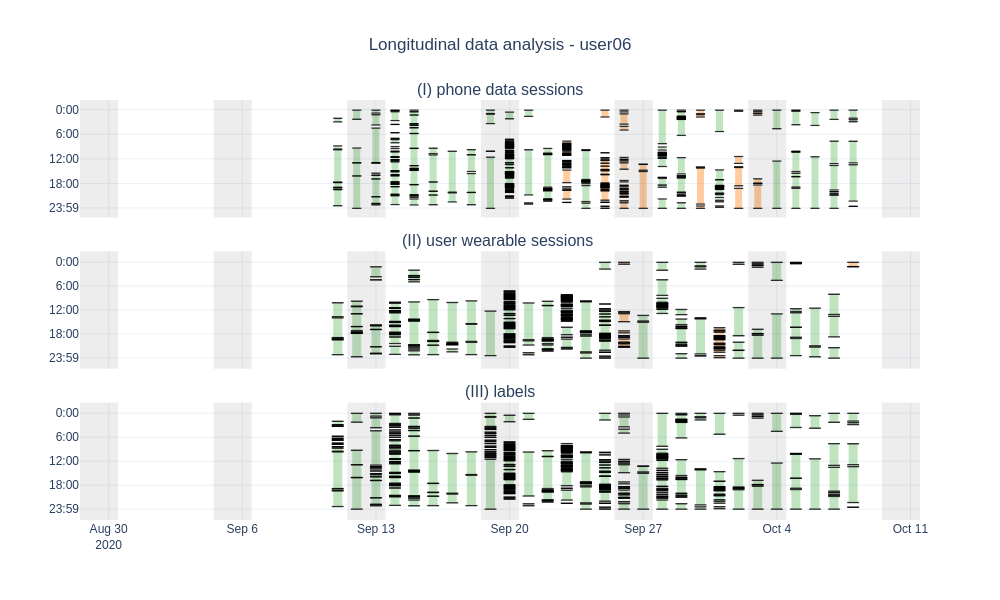

In [7]:
user = "user06"
df_wrist_wearable_sessions = get_wearable_session_df(
    processed_etri_path.glob(f"{user}/e4Eda*"), 0.1
)
df_phone_sessions = get_wearable_session_df(
    processed_etri_path.glob(f"{user}/mGps*"), 0.05
)
df_labels_session = get_label_interaction_df(df_label_tot[df_label_tot.user == user])

# ------------------------- create the user figure ------------------------
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    subplot_titles=[
        "(I) phone data sessions",
        "(II) user wearable sessions ",
        "(III) labels",
    ],
    vertical_spacing=0.08,
)
fig.update_layout(height=700, title=f"Longitudinal data analysis - {user}", title_x=0.5)

legend_names = []
dt = df_wrist_wearable_sessions.start.iloc[0].replace(hour=0, minute=0, second=0)
to_same_date = lambda time: datetime.combine(dt.date(), time)

for row, col in [(1, 1), (2, 1), (3, 1)]:
    fig.update_yaxes(
        type="date",
        tickformat="%H:%M",
        tickmode="array",
        ticktext=["0:00", "6:00", "12:00", "18:00", "23:59"],
        tickvals=[
            dt.replace(hour=0),
            dt.replace(hour=6),
            dt.replace(hour=12),
            dt.replace(hour=18),
            dt.replace(hour=23, minute=59),
        ],
        autorange='reversed',
        row=row,
        col=col,
    )

# 0. add the phone session time
for _, session in df_phone_sessions.iterrows():
    hours, remainder = divmod(session.daily_wear_time.total_seconds(), 3600)
    minutes, seconds = divmod(remainder, 60)

    name = "too short " if session.daily_wear_time < pd.Timedelta(hours=12) else ""
    name += f"phone sessions - {user}"

    fig.add_trace(
        go.Scattergl(
            x=[session.date] * 2,
            y=[
                to_same_date(session.start.time()),
                to_same_date(session.end.time()),
            ],
            line=dict(
                color=(
                    "rgba(44, 160, 44, 0.3)"  # cooked asparagus green
                    if session.daily_wear_time > pd.Timedelta(hours=12)
                    else "rgba(255, 127, 14, 0.4)"  # safety orange
                ),
                width=7,
            ),
            mode="markers+lines",
            marker=dict(
                line_color="black",
                line_width=1,
                color="black",
                symbol="line-ew",
                size=6,
                opacity=0.8,
            ),
            name=name,
            legendgroup=user + "phone data",
            showlegend=False and name not in legend_names,
            hovertext=f"total phone data time = {int(hours)}u{int(minutes)}",
        ),
        row=1,
        col=1,
    )
    legend_names.append(name)

# 1. add the user wear time
legend_names = []
for _, session in df_wrist_wearable_sessions.iterrows():
    hours, remainder = divmod(session.daily_wear_time.total_seconds(), 3600)
    minutes, seconds = divmod(remainder, 60)

    name = "too short " if session.daily_wear_time < pd.Timedelta(hours=6) else ""
    name += f"wearable sessions - {user}"

    fig.add_trace(
        go.Scattergl(
            x=[session.date] * 2,
            y=[
                to_same_date(session.start.time()),
                to_same_date(session.end.time()),
            ],
            line=dict(
                color=(
                    "rgba(44, 160, 44, 0.3)"  # cooked asparagus green
                    if session.daily_wear_time > pd.Timedelta(hours=6)
                    else "rgba(255, 127, 14, 0.4)"  # safety orange
                ),
                width=9,
            ),
            mode="markers+lines",
            marker=dict(
                line_color="black",
                line_width=1,
                color="black",
                symbol="line-ew",
                size=8,
                opacity=0.8,
            ),
            name=name,
            legendgroup=user + "wearable data",
            showlegend=False and name not in legend_names,
            hovertext=f"total daily wear time = {int(hours)}u{int(minutes)}",
        ),
        row=2,
        col=1,
    )
    legend_names.append(name)

# 3. Add the label sessions
# for _, session in df_labels_session[df_labels_session['session_dur'] > pd.Timedelta('5 min')].iterrows():
for _, session in df_labels_session.iterrows():
    hours, remainder = divmod(session.daily_wear_time.total_seconds(), 3600)
    minutes, seconds = divmod(remainder, 60)

    name = f"label sessions - {user}"

    fig.add_trace(
        go.Scattergl(
            x=[session.date] * 2,
            y=[
                to_same_date(session.start.time()),
                to_same_date(session.end.time()),
            ],
            line=dict(
                color=(
                    "rgba(44, 160, 44, 0.3)"  # cooked asparagus green
                    if session.daily_wear_time > pd.Timedelta(hours=6)
                    else "rgba(255, 127, 14, 0.4)"  # safety orange
                ),
                width=9,
            ),
            mode="markers+lines",
            marker=dict(
                line_color="black",
                line_width=1,
                color="black",
                symbol="line-ew",
                size=8,
                opacity=0.8,
            ),
            name=name,
            legendgroup=user + "wearable data",
            showlegend=False and name not in legend_names,
            hovertext=f"total label time = {int(hours)}u{int(minutes)}",
        ),
        row=3,
        col=1,
    )
    legend_names.append(name)


df_label_tot_u = df_label_tot[df_label_tot.user == "user01"]
dr = pd.date_range(
    df_label_tot_u["timestamp"].min().date() - pd.Timedelta(days=4),
    df_label_tot_u["timestamp"].max().date() + pd.Timedelta(days=14),
)
for sat in np.unique(dr[dr.dayofweek == 5]):
    fig.add_vrect(
        x0=pd.Timestamp(sat) - pd.Timedelta(hours=12),
        x1=pd.Timestamp(sat) + pd.Timedelta(hours=36),
        fillcolor="rgba(0, 0, 0, .07)",
        line_width=0,
    )

fig.update_layout(template="plotly_white")
fig.show(renderer="png", width=1000, height=600)

In [8]:
fig.write_html(
    figure_dir / "interaction_rate_ETRI.html", include_plotlyjs="cdn", full_html=False
)